# Universal

In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os

These are some convenience function for plotting and loading data.

In [3]:
#convenience function
path_models = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","models")
path_scenes = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","scenes")

def get_path_model(index):
    return os.path.join(path_models, f"{index}.jpg")

def get_path_scene(index):
    return os.path.join(path_scenes, f"{index}")

#drawing functions
def plot_images(image_paths):

    images = [cv.imread(p) for p in image_paths]

    # Check if the list is empty
    if not images:
        raise ValueError("The list of images is empty.")

    # Find the maximum height among all images
    max_height = max(img.shape[0] for img in images)

    # Resize all images to have the same height
    resized_images = [
        cv.resize(img, (int(img.shape[1] * max_height / img.shape[0]), max_height))
        for img in images
    ]

    # Horizontally concatenate images
    concatenated_image = np.hstack(resized_images)
    print([os.path.split(p)[-1] for p in image_paths])
    plt.imshow(cv.cvtColor(concatenated_image, cv.COLOR_BGR2RGB))
    plt.title("models")
    plt.show()

def draw_good_and_bad_matches(scene, good, bad, kp_scene):
#draw excluded and included matches
        for o in bad:
            x,y = kp_scene[o.trainIdx].pt
            coord = [int(x), int(y)]
            cv.circle(scene, coord, 3, (0,0,255), 2)

        for o in good:
            x,y = kp_scene[o.trainIdx].pt  # Get match coordinates
            coord = [int(x), int(y)]
            cv.circle(scene, coord, 3, (0,255,0), 2)

        plt.imshow(cv.cvtColor(scene, cv.COLOR_BGR2RGB))
        plt.title("Good and Bad (rejected) matches")
        plt.show()

def draw_matches(model, kp_model, scene, kp_scene, good):
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                        singlePointColor = None, # not draw keypoints only matching lines
                        flags = 2) # not draw keypoints only lines
    image = cv.drawMatches(model, kp_model, scene, kp_scene, good, None,**draw_params)
    plt.title("Matched keypoints")
    plt.imshow(image)
    plt.show()

In [4]:
class Product:
  def __init__(self, position, width, height, cornerpoints):
    self.position = position
    self.width = width
    self.height = height
    self.cornerpoints = cornerpoints

def product_recognition(scene, models, result):
    scene_img = cv.imread(get_path_scene(scene))
    for i in range(len(models)):
        if result[i] is not None:
            print(f"Product {models[i]} instance found:")
            print("\tInstance {}: position: {}, width: {}px, height: {}px".format(i,
                                                                                  result[i].position,
                                                                                  result[i].width,
                                                                                  result[i].height) )
            cv.rectangle(scene_img,
                         (result[i].position[0] - int(result[i].width/2),
                          result[i].position[1] - int(result[i].height/2)),
                         (result[i].position[0] + int(result[i].width/2),
                          result[i].position[1] + int(result[i].height/2)),
                         (0,255,0),3)

            #add square and add text
            means = np.mean(result[i].cornerpoints, axis=0)
            x, y = [a for a in means[0]]
            x = x * 0.9 #adjust for text
            boldness = 3
            size = 3

            cv.putText(scene_img, str(models[i]), (int(x),int(y)), cv.FONT_HERSHEY_COMPLEX_SMALL, size, (0, 0, 255, 255), boldness, cv.LINE_AA)

    plt.imshow(cv.cvtColor(scene_img, cv.COLOR_BGR2RGB))
    plt.show()

# Step A - Multiple Product Detection:


The Task of Step A:

"Develop an object detection system to identify single instance of products given: one reference image for
each item and a scene image. The system should be able to correctly identify all the product in the shelves
image. One way to solve this task could be the use of local invariant feature as explained in lab session 5."

As proposed in the task description, we will utilize local invariant features to match a reference model with a scene image. This approach involves detecting keypoints and descriptors using SIFT, then matching them using the k-nearest neighbors algorithm. To filter out incorrect matches, we apply Lowe’s ratio test, retaining only the best matches. Finally, the remaining matches are used to determine the location of the model in the scene.

### Source
https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html


## Example Execution
In this first example, we will only try to locate cereal box 0 in scene e1 for simplicity’s sake.

In [5]:
scene_path = get_path_scene("e1.png")
model_path = get_path_model(0)
plot_diagrams=False

if plot_diagrams:
    plot_images(model_path)

scene_gray = cv.imread(scene_path, cv.IMREAD_GRAYSCALE)
scene_to_draw_on = cv.imread(scene_path)
model_gray = cv.imread(model_path, cv.IMREAD_GRAYSCALE)

## SIFT (Scale Invariant Feature Transform)
In this step we use SIFT to determine both the Keypoint's and descriptors of both the model and the scene. Sift works by following a few steps;
1. Keypoint Detection: SIFT determines keypoint locations using the Difference of Gaussians (DoG) function. A potential keypoint is identified as a local extremum in both scale and space within the DoG representation.
2. Keypoint Refinement: The initial set of keypoints includes many unstable points, which need to be refined. To improve accuracy, Taylor series expansion is used to localize keypoints more precisely. Keypoints found along edges are often unstable, so another pruning step based on the eigenvalues of the Hessian is necessary. If the curvature ratio exceeds a certain threshold, the keypoint is discarded.
3. Orientation Assignment: To ensure invariance to image rotation, each keypoint is assigned a canonical orientation. The keypoint’s neighborhood is divided into an orientation histogram with 36 bins, each covering 10 degrees. The dominant gradient direction is selected as the keypoint’s orientation, and any additional peaks above 80% of the maximum are also considered.
4. Descriptor Computation: Once keypoints are detected, descriptors are computed based on the surrounding area. The local region around each keypoint is divided into a grid, typically forming a 4×4 array of orientation histograms, with each histogram having 8 orientation bins. This results in a feature vector of 128 dimensions, which represents the keypoint descriptor.

Source: https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html

Visualization of keypoints in model image:


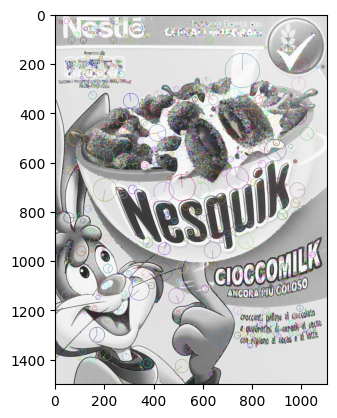

In [6]:
# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp_model, des_model = sift.detectAndCompute(model_gray,None)
kp_scene, des_scene = sift.detectAndCompute(scene_gray,None)

img_visualization = cv.drawKeypoints(model_gray,kp_model,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print("Visualization of keypoints in model image:")
plt.imshow(img_visualization)
plt.show()

## Keypoint Matching
To match keypoints between the model and the scene, a nearest-neighbor algorithm is applied to the descriptors. However, a challenge arises when the difference between the best match and the second-best match is small, because this implies a low accuracy of the first match.

To reduce false matches, Lowe’s ratio test is used. This test computes the ratio between the best match and the second-best match. If the ratio is above a certain threshold, the match is rejected, as it suggests ambiguity. Lowe originally proposed a threshold of 0.8, but in our case, we use 0.7, as it was used in Lab Session 5.

Source: https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html

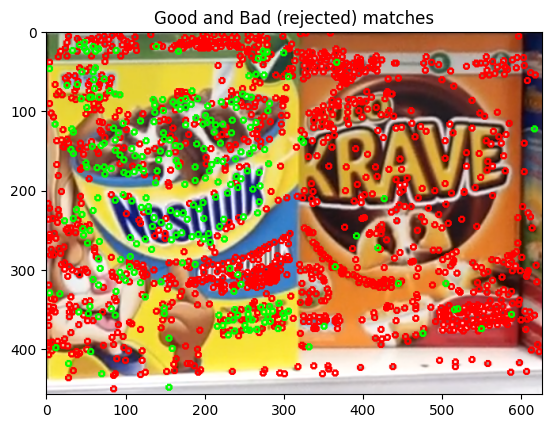

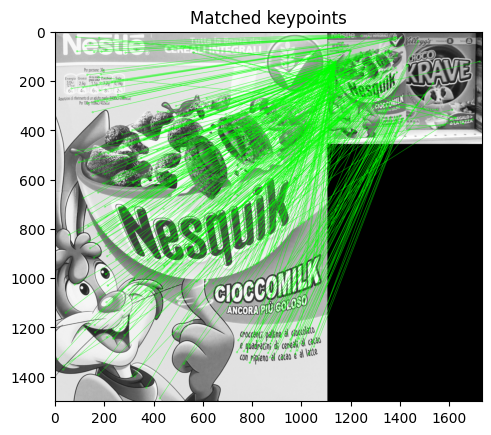

In [7]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des_model,des_scene,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
bad = []
for m,n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
    else:
        bad.append(m)

draw_good_and_bad_matches(scene_to_draw_on, good, bad, kp_scene)
draw_matches(model_gray, kp_model, scene_gray, kp_scene, good)

## Homography and Perspective Transform
Once the model has been matched with the scene, the next step is to compute the homography, which describes how the model image has been scaled, rotated, and transformed in the scene.

The homography matrix can be derived from the matched keypoints. Using this transformation, OpenCV’s cv2.perspectiveTransform() function can be applied to find the coordinates of the four corner points of the model (e.g., a cereal box) in the scene.

During this process, it is important to note that just because a model produces a few matches, it does not necessarily mean it is present in the scene. To address this issue, a simple threshold on the minimum number of matches can be applied.

Setting an appropriate threshold can be challenging for large datasets, but in this case, where only a small number of models and scenes are considered, manually choosing a threshold is sufficient.

Enough matches are found - 457/200
------------------------------------------
Result:


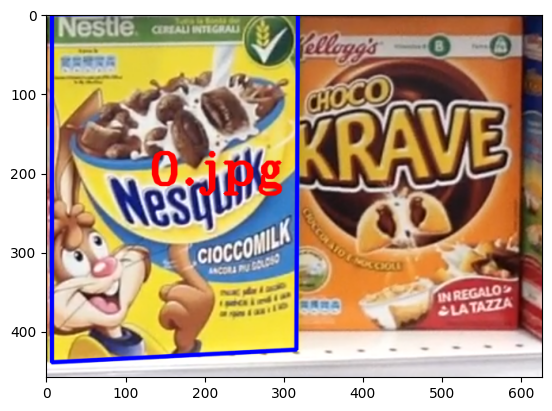

In [8]:
MIN_MATCH_COUNT = 200
scene_to_draw_on = cv.imread(scene_path)

if len(good)>MIN_MATCH_COUNT:
    print( "Enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    h,w = model_gray.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    dst = cv.perspectiveTransform(pts,M)

    #add square and add text
    means = np.mean(dst, axis=0)
    x, y = [a for a in means[0]]
    x = x * 0.8 #adjust for text

    result = cv.polylines(scene_to_draw_on,[np.int32(dst)],True,255,3, cv.LINE_AA)

    boldness = 3
    size = 3
    cv.putText(scene_to_draw_on, "0.jpg", (int(x),int(y)), cv.FONT_HERSHEY_COMPLEX_SMALL, size, (0, 0, 255, 255), boldness, cv.LINE_AA)

else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )

print("------------------------------------------")
print("Result:")
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

## Solution
In the following section, all proposed steps will be bundled into a single function, which takes multiple models and a scene as input and returns the locations of the models in the scene. Additionally, all models are scaled to the same size, matching the smallest model, since we found that an  incorrect model with a high resolution could sometimes produce more matches than the correct model with a lower resolution.

The following code demonstrates that this approach successfully locates the model in simple scenes. However, as scene complexity increases (e.g., when two identical cereal boxes are present), the method begins to struggle. That’s why, in Step B, we will improve this approach by utilizing the Generalized Hough Transform.

In [9]:
def find_image_A(scene_path, model_paths):
    scene_gray = cv.imread(scene_path,cv.IMREAD_GRAYSCALE)

    #create array with all models
    models = []
    for model_gray_path in model_paths:
        name = os.path.split(model_gray_path)[-1]
        models.append({
            "name": name,
            "img": cv.imread(model_gray_path, cv.IMREAD_GRAYSCALE)
            })

    common_height = np.min([o["img"].shape[0] for o in models])

    results = []

    for model in models:
        model_gray = model["img"]
        ratio = common_height/model_gray.shape[0]
        new_w = model_gray.shape[1]*ratio
        model_gray = cv.resize(model_gray, (int(new_w), common_height), interpolation=cv.INTER_AREA)
        MIN_MATCH_COUNT = 200

        # Initiate SIFT detector
        sift = cv.SIFT_create()

        # find the keypoints and descriptors with SIFT
        kp_model, des_model = sift.detectAndCompute(model_gray,None)
        kp_scene, des_scene = sift.detectAndCompute(scene_gray,None)

        #MIN_MATCH_PERCENTAGE_THRESHOLD = int(len(kp_model) * MIN_MATCH_PERCENTAGE/100)

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des_model,des_scene,k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        bad = []
        for m,n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)
            else:
                bad.append(m)

        if len(good)>MIN_MATCH_COUNT:
            src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
            h,w = model_gray.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            
            dst = cv.perspectiveTransform(pts,M)

            # Compute height as the average of two height measurements
            height = int(((dst[1][0][1] - dst[0][0][1]) + (dst[2][0][1] - dst[3][0][1])) / 2)

            # Compute width as the average of two width measurements
            width = int(((dst[3][0][0] - dst[0][0][0]) + (dst[2][0][0] - dst[1][0][0])) / 2)

            # Compute center X coordinate
            x = int(((dst[3][0][0] - (dst[3][0][0] - dst[0][0][0]) / 2) +
                     (dst[2][0][0] - (dst[2][0][0] - dst[1][0][0]) / 2)) / 2)

            # Compute center Y coordinate
            y = int(((dst[1][0][1] - (dst[1][0][1] - dst[0][0][1]) / 2) +
                     (dst[2][0][1] - (dst[2][0][1] - dst[3][0][1]) / 2)) / 2)

            # Create product object and append to result list
            results.append(Product((x, y), width, height, dst))
        else:
            results.append(None)
    return results

### Scene e1

Product 0 instance found:
	Instance 0: position: (162, 214), width: 308px, height: 431px


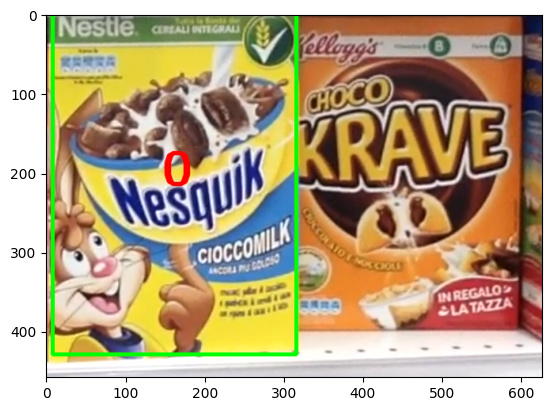

In [10]:
#define models to be searched in image
scene = "e1.png"
models = [0, 1, 11, 19, 24, 26, 25]

result = find_image_A(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene, models, result)

### Scene e2

Product 24 instance found:
	Instance 4: position: (167, 219), width: 334px, height: 488px
Product 26 instance found:
	Instance 5: position: (538, 218), width: 332px, height: 485px


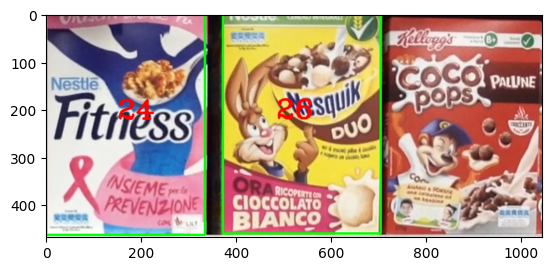

In [11]:
#define models to be searched in image
scene = "e2.png"
models = [0, 1, 11, 19, 24, 26, 25]

result = find_image_A(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene, models, result)

### Scene e3

Product 0 instance found:
	Instance 0: position: (170, 235), width: 323px, height: 438px


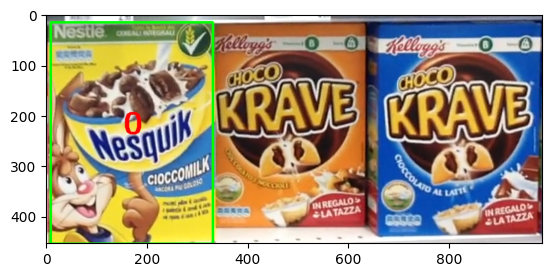

In [12]:
scene = "e3.png"
models = [0, 1, 11, 19, 24, 26, 25]

result = find_image_A(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene, models, result)

### Scene e4

Product 0 instance found:
	Instance 0: position: (158, 738), width: 323px, height: 438px
Product 26 instance found:
	Instance 5: position: (205, 195), width: 340px, height: 493px


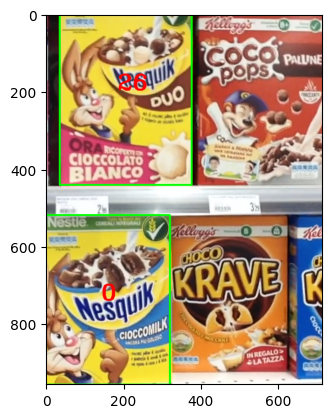

In [13]:
scene = "e4.png"
models = [0, 1, 11, 19, 24, 26, 25]

result = find_image_A(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene, models, result)

### Scene e5

Product 19 instance found:
	Instance 3: position: (504, 190), width: 295px, height: 383px


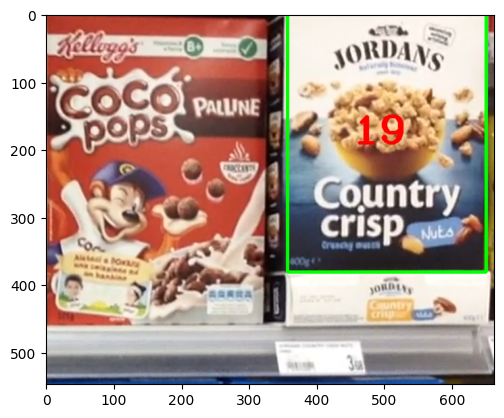

In [14]:
scene = "e5.png"
models = [0, 1, 11, 19, 24, 26, 25]

result = find_image_A(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene, models, result)